# 📚 Plant Disease Classification with CNN using TensorFlow

---

## 🔧 1. Install & Import Dependencies
```python
!pip install tensorflow tensorflow-datasets matplotlib seaborn
```

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Activation, Dropout,
                                     BatchNormalization, GlobalAveragePooling2D, Dense, Input)
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

---

## 📥 2. Load the PlantVillage Dataset

In [7]:
(ds_train, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features['label'].names
num_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")
print("Class names:", class_names)

Number of classes: 38
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato

---

## 🧹 3. Preprocess & Prepare the Data

In [8]:
IMG_SIZE = 128
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)

ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)

---

## 🖼️ 4. Visualize Sample Images

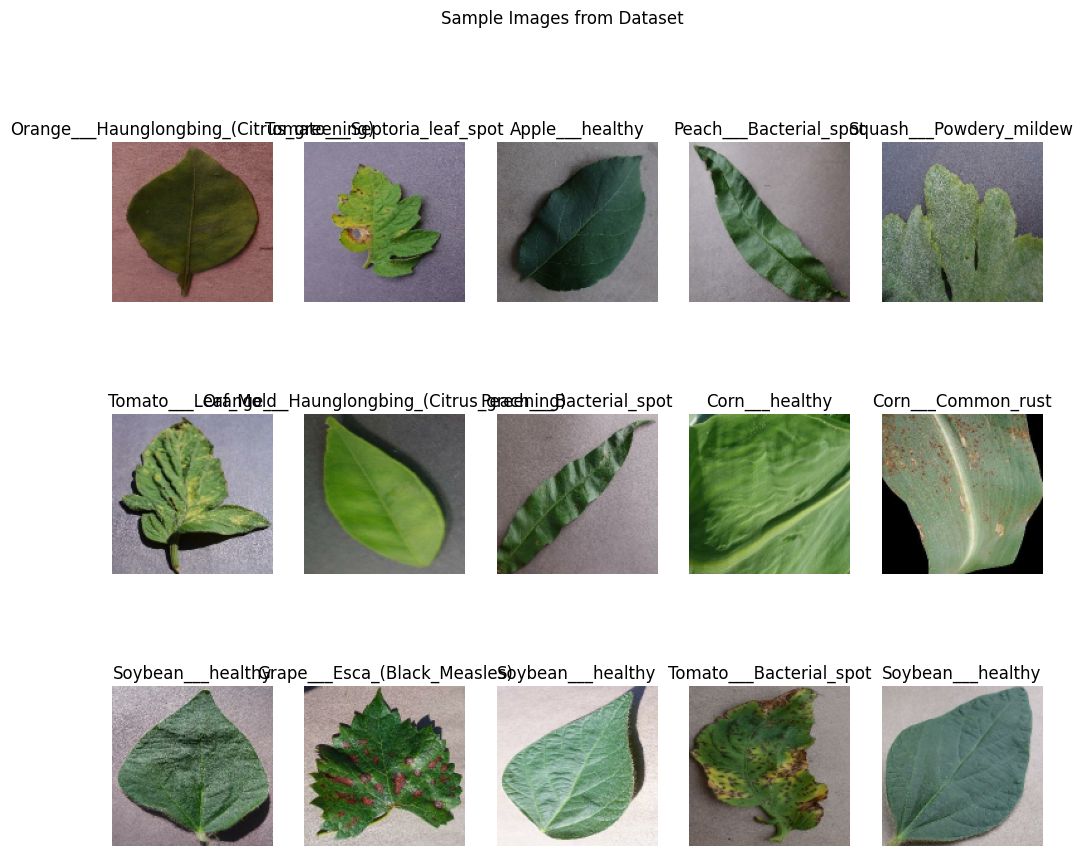

In [9]:
plt.figure(figsize=(12, 10))
for images, labels in ds_train.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.suptitle("Sample Images from Dataset")
plt.show()

---

## 📊 5. Visualize Class Distribution

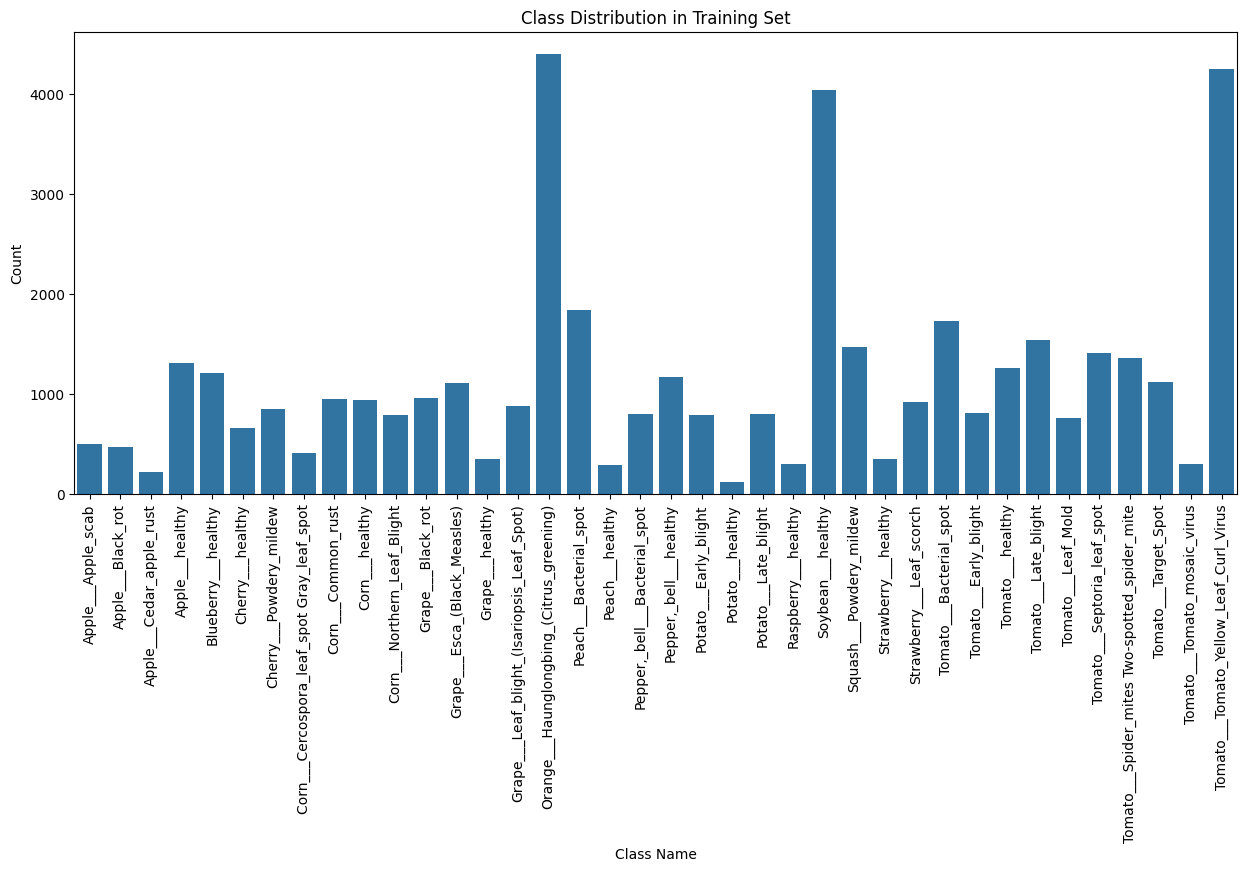

In [13]:
label_counts = {i: 0 for i in range(num_classes)}

# Safely extract integer label
for _, label in tfds.as_numpy(ds_train.unbatch()):
    label = int(label[()])  # Extracts scalar value from 0-dim array
    label_counts[label] += 1

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(x=[class_names[i] for i in label_counts.keys()], y=list(label_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.ylabel("Count")
plt.xlabel("Class Name")
plt.show()

---

## 🏗️ 6. Build the CNN Model

In [14]:
# Define input shape parameters
height, width, depth = IMG_SIZE, IMG_SIZE, 3
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

In [15]:
# Create the model
model = Sequential()
model.add(Input(shape=inputShape))

# Conv Block 1
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Global Average Pooling + Dense layers
model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 449,190 (1.71 MB)

 Trainable params: 447,782 (1.71 MB)

 Non-trainable params: 1,408 (5.50 KB)

---

## 🚀 7. Train the Model

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=50,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 88s 55ms/step - accuracy: 0.5294 - loss: 1.7449 - val_accuracy: 0.2854 - val_loss: 5.5970 - learning_rate: 0.0010
Epoch 2/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 68s 49ms/step - accuracy: 0.8003 - loss: 0.6471 - val_accuracy: 0.5535 - val_loss: 1.7529 - learning_rate: 0.0010
Epoch 3/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 80s 48ms/step - accuracy: 0.8656 - loss: 0.4191 - val_accuracy: 0.6292 - val_loss: 1.7104 - learning_rate: 0.0010
Epoch 4/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 83s 49ms/step - accuracy: 0.9009 - loss: 0.3089 - val_accuracy: 0.7398 - val_loss: 0.9279 - learning_rate: 0.0010
Epoch 5/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.9260 - loss: 0.2375 - val_accuracy: 0.8150 - val_loss: 0.6796 - learning_rate: 0.0010
Epoch 6/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 65s 48ms/step - accuracy: 0.9354 - loss: 0.2043 - val_accuracy: 0.7762 - val_loss: 0.9279 - learning_rate: 0.0010
Epoch 7/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 67s 49ms/step - accura

---

## 📈 8. Visualize Training Performance

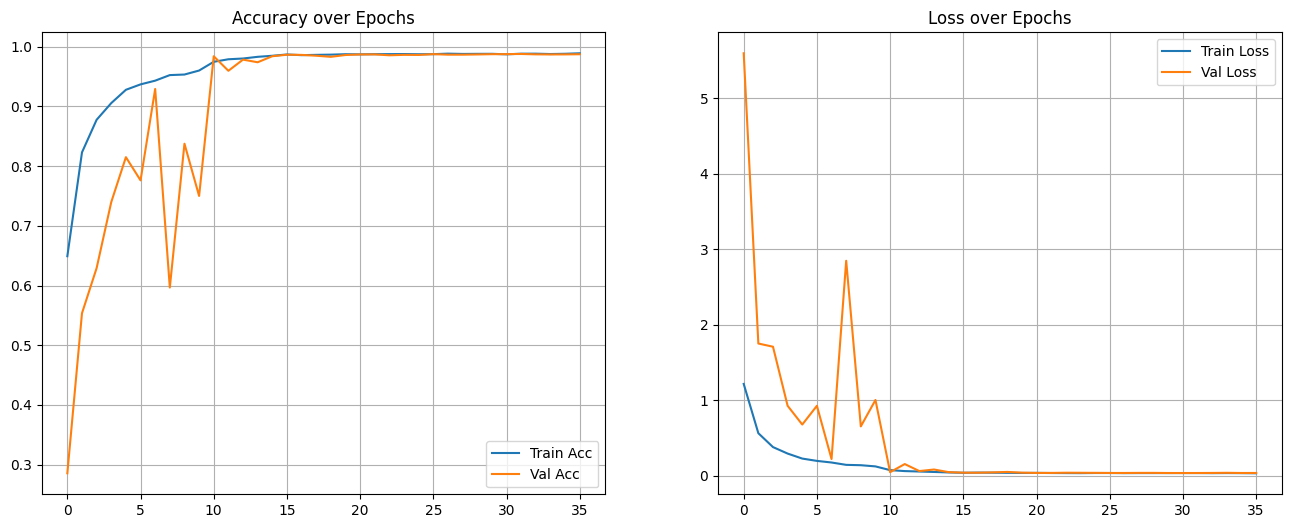

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.show()

---

## 📊 9. Evaluate Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

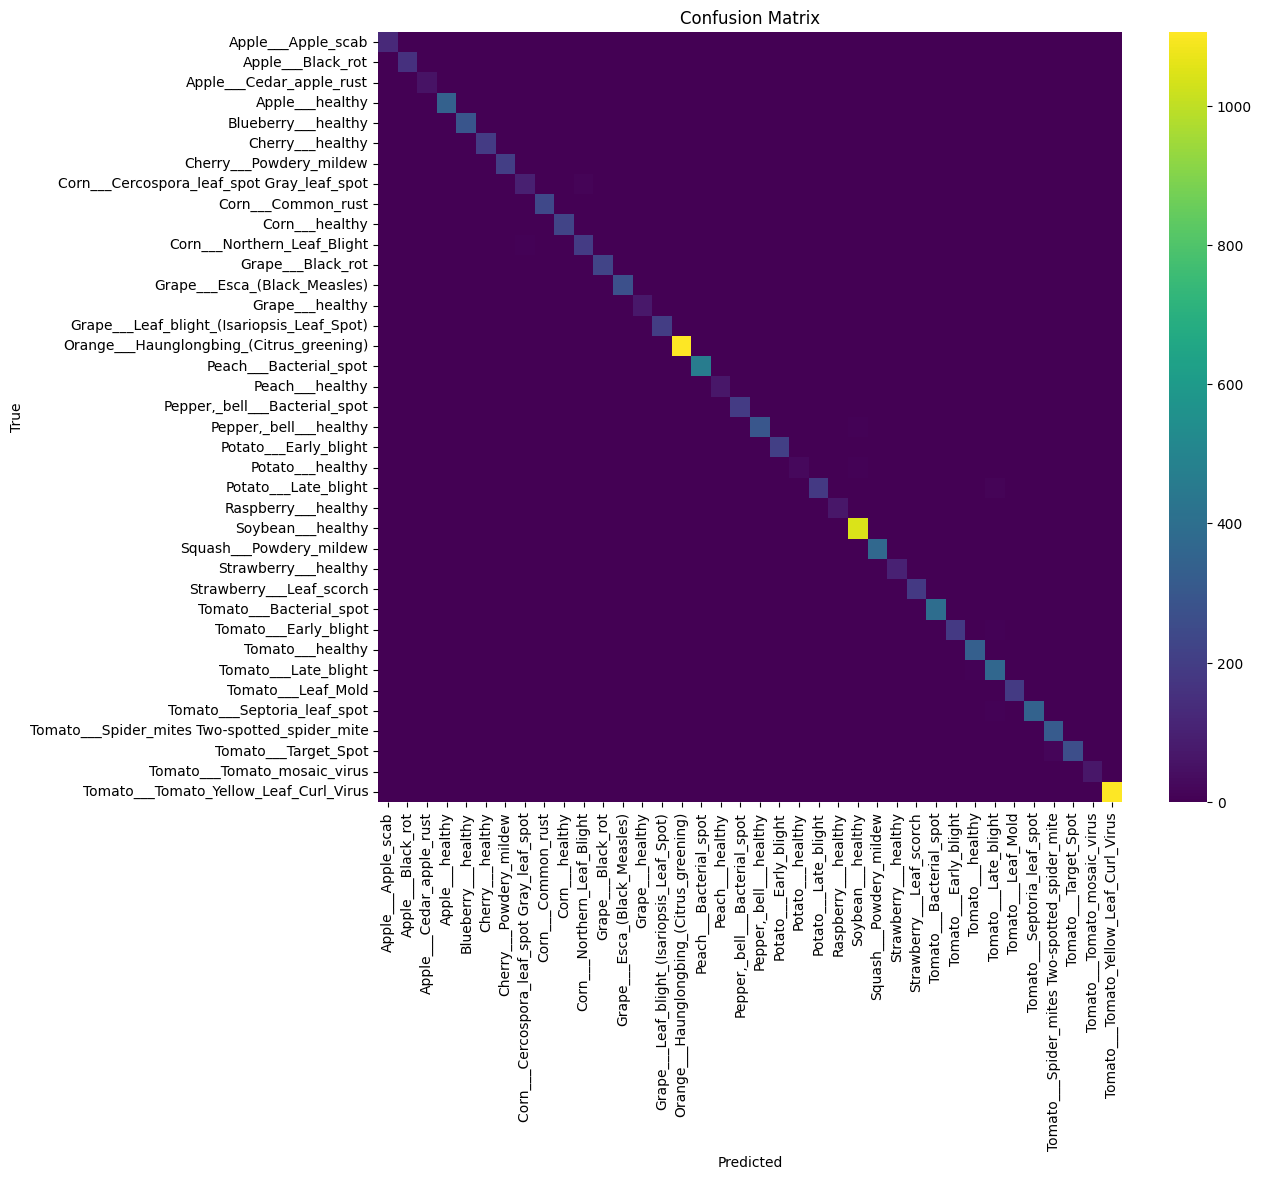

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.99      1.00       129
                            Apple___Black_rot       0.99      0.99      0.99       154
                     Apple___Cedar_apple_rust       1.00      1.00      1.00        54
                              Apple___healthy       0.98      1.00      0.99       339
                          Blueberry___healthy       0.99      1.00      1.00       292
                             Cherry___healthy       1.00      0.99      1.00       195
                      Cherry___Powdery_mildew       0.99      0.99      0.99       201
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.90      0.92       108
                           Corn___Common_rust       1.00      1.00      1.00       239
                               Corn___healthy       1.00      1.00      1.00       223
                  Corn___Northern_Leaf_Bli

In [20]:
# Get predictions
true_labels = []
pred_labels = []
for images, labels in ds_test:
    preds = model.predict(images)
    true_labels.extend(labels.numpy())
    pred_labels.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels, target_names=class_names))

## 💾 10. Save the Model

In [21]:
model.save('plant_disease_model.keras')

## 🔮 11. Make Predictions on New Images

In [36]:
# Load the saved model
_model = tf.keras.models.load_model("plant_disease_model.keras")

def preprocess_single_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return tf.expand_dims(image, axis=0)

# Make prediction
image_path = 'leaf1.jpg'
image = preprocess_single_image(image_path)
pred = _model.predict(image)
label = class_names[np.argmax(pred)]
print(f"[☑️] Predicted class: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
[☑️] Predicted class: Tomato___Bacterial_spot
